# Loading Spike Waveforms

In [1]:
# Turn off logging and disable tqdm this is a hidden cell on docs page
import logging
import os

logger = logging.getLogger('ibllib')
logger.setLevel(logging.CRITICAL)

os.environ["TQDM_DISABLE"] = "1"

## Loading the spike sorting and average waveforms

In [2]:
%%capture
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader

one = ONE(base_url='https://openalyx.internationalbrainlab.org')

pid = 'da8dfec1-d265-44e8-84ce-6ae9c109b8bd'

# Load in the spikesorting
ssl = SpikeSortingLoader(pid=pid, one=one)
spikes, clusters, channels = ssl.load_spike_sorting(revision='2024-05-06')
clusters = ssl.merge_clusters(spikes, clusters, channels)
waveforms = ssl.load_spike_sorting_object('waveforms')




## Displaying a few average waveforms

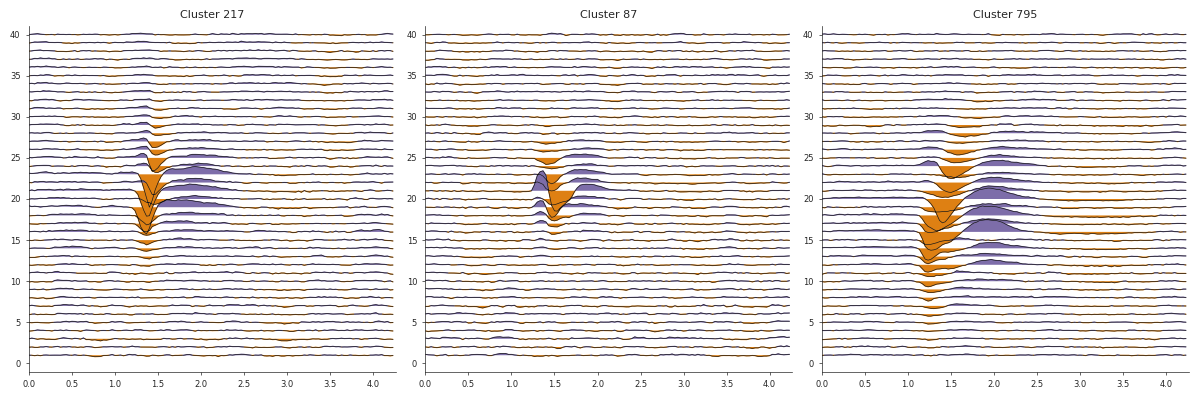

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import ibldsp.waveforms
from ibl_style.style import figure_style
figure_style()

cids = np.random.choice(np.where(clusters['label'] == 1)[0], 3)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, cid in enumerate(cids):
    wf = waveforms['templates'][cid, :, :]
    ax = ibldsp.waveforms.double_wiggle(wf * 1e6 / 80, fs=30_000, ax=axs[i])
    ax.set(title=f'Cluster {cid}')

## More details
During spike sorting, pre-processing operations are performed on the voltage data to create the average templates.
 Although those templates are useful for clustering, they may not be the best description of the neural activity.
 As such we extract average waveforms for each cluster using a different pre-processing. Details are provided on the spike sorting white paper [on figshare](https://figshare.com/articles/online_resource/Spike_sorting_pipeline_for_the_International_Brain_Laboratory/19705522?file=49783080).
* [Description of datasets](https://docs.google.com/document/d/1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg/edit?tab=t.0#heading=h.i89jwttog3fq)

## Exploring the raw waveforms
For each unit, we compiled up to raw data 256 waveforms chosen randomly from the entire recording.
The pre-processing steps included rephasing of the channels, low-cut filtering, bad channel detection and common-average referencing.

To perform the loading we will use a convenience.

Warning, this will download a few Gigabytes of data to your computer !

### Compute average waveform for cluster
Here we will load data from the striatum and compute the average wvaeform for several stack orders: 1, 2, 4, 8, 16, 32, 64, 128 and display the resulting waveform.

100%|██████████| 12/12.0 [00:03<00:00,  3.00it/s]


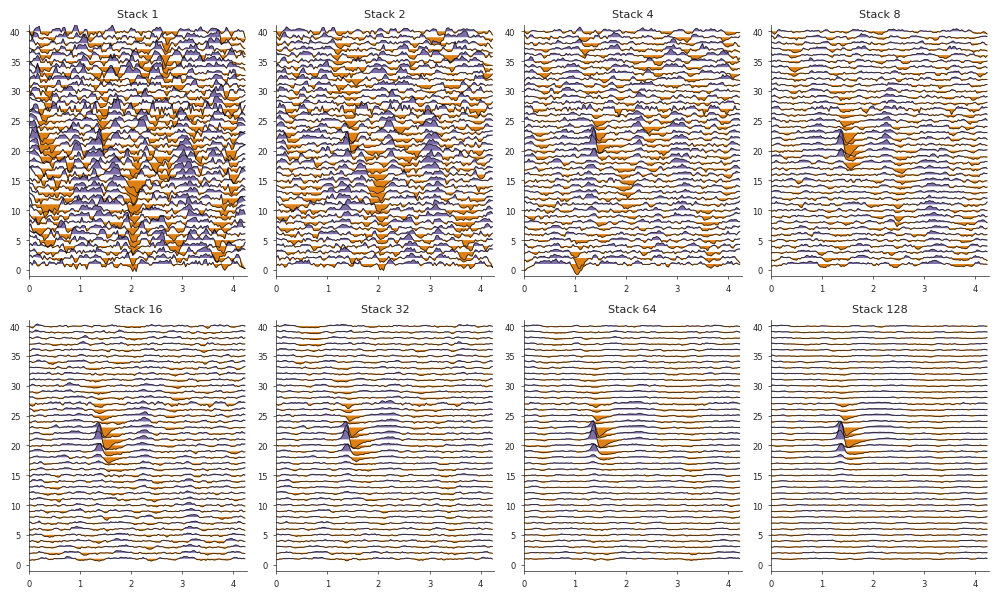

In [7]:
from ibldsp.utils import rms
# instantiating the waveform loader will download the raw waveform arrays and can take a few minutes (~3Gb)
wfl = ssl.raw_waveforms()
ic = np.where(np.logical_and(clusters['acronym'] == 'LSr', clusters['bitwise_fail'] == 0))[0]
# look at templates

raw_wav, info, channel_map = wfl.load_waveforms(labels=ic[12])

snr = np.zeros(8)
fig, axs = plt.subplots(2, 4, figsize=(10, 6))
for i, ax in enumerate(axs.flat):
    w_stack = np.mean(raw_wav[0, :(2 ** i), :, :], axis=0)
    ax = ibldsp.waveforms.double_wiggle( w_stack  * 1e6 / 80, fs=30_000, ax=axs.flatten()[i])
    ax.set_title(f"Stack {2 ** i}")
    snr[i] = 20 * np.log10(rms(w_stack[19:22, wfl.trough_offset - 10:wfl.trough_offset + 10].flatten()) / np.mean(rms(w_stack)))

For constant gaussian noise in `n` repeated experiments, we expect the SNR to scale proportionally to the square root of `n`.
In decibels, this corresponds to 3dB / octave. Let's see how the data compares to the prediction:

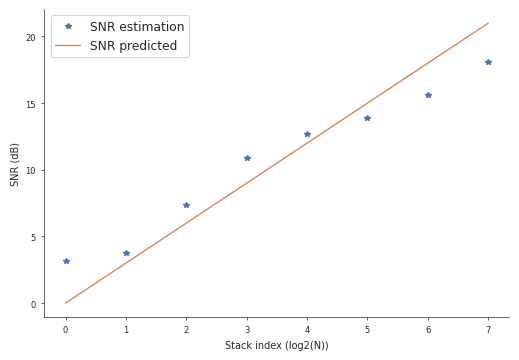

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.arange(8), snr, '*', label='SNR estimation')
ax.plot(np.arange(8), np.arange(8) * 3, label='SNR predicted')
ax.set(xlabel='Stack index (log2(N))', ylabel='SNR (dB)')
ax.legend()